In [31]:
#Manipulacion de datos

import numpy as np
import pandas as pd

#Vilualizacion

import matplotlib.pyplot as plt
import seaborn as sns

#Sql

import sqlite3

#working directory

import os 
os.getcwd()

# Classifier
from sklearn import tree

# Pre-processing
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Tune and cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [14]:
#data
path = "/home/ronald/Documentos/Datos Sql/database.sqlite" 
conn = sqlite3.connect(path)

In [15]:
pd.read_sql("""

SELECT *
FROM sqlite_master
WHERE type='table';

""", conn)

,type,name,tbl_name,rootpage,sql
0,table,primary_results,primary_results,2,CREATE TABLE primary_results (\n state TEXT...
1,table,county_facts,county_facts,3,CREATE TABLE county_facts (\n fips INTEGER ...
2,table,county_facts_dictionary,county_facts_dictionary,5,CREATE TABLE county_facts_dictionary(\n col...


In [16]:
pd.read_sql("""

SELECT * 
FROM primary_results
LIMIT 5;

""", conn)

,state,state_abbreviation,county,fips,party,candidate,votes,fraction_votes
0,Alabama,AL,Autauga,1001,Democrat,Bernie Sanders,544,0.182
1,Alabama,AL,Autauga,1001,Democrat,Hillary Clinton,2387,0.800
2,Alabama,AL,Baldwin,1003,Democrat,Bernie Sanders,2694,0.329
3,Alabama,AL,Baldwin,1003,Democrat,Hillary Clinton,5290,0.647
4,Alabama,AL,Barbour,1005,Democrat,Bernie Sanders,222,0.078


In [17]:
pd.read_sql("""

SELECT * 
FROM county_facts
LIMIT 5;

""", conn)

,fips,area_name,state_abbreviation,PST045214,PST040210,PST120214,POP010210,AGE135214,AGE295214,AGE775214,...,SBO415207,SBO015207,MAN450207,WTN220207,RTN130207,RTN131207,AFN120207,BPS030214,LND110210,POP060210
0,0,United States,,318857056,308758105,3.3,308745538,6.2,23.1,14.5,...,8.3,28.8,5319456312,4174286516,3917663456,12990,613795732,1046363,3531905.43,87.4
1,1000,Alabama,,4849377,4780127,1.4,4779736,6.1,22.8,15.3,...,1.2,28.1,112858843,52252752,57344851,12364,6426342,13369,50645.33,94.4
2,1001,Autauga County,AL,55395,54571,1.5,54571,6.0,25.2,13.8,...,0.7,31.7,0,0,598175,12003,88157,131,594.44,91.8
3,1003,Baldwin County,AL,200111,182265,9.8,182265,5.6,22.2,18.7,...,1.3,27.3,1410273,0,2966489,17166,436955,1384,1589.78,114.6
4,1005,Barbour County,AL,26887,27457,-2.1,27457,5.7,21.2,16.5,...,0.0,27.0,0,0,188337,6334,0,8,884.88,31.0


In [19]:
#Se guarda la informacion sobre una variable llamada dictionary

dictionary = pd.read_sql("""

SELECT *
FROM county_facts_dictionary;

""", conn)

In [20]:
#Candidatos Republicanos

pd.read_sql("""

SELECT DISTINCT candidate
FROM primary_results
WHERE party = 'Republican';

""", conn)

,candidate
0,Ben Carson
1,Donald Trump
2,John Kasich
3,Marco Rubio
4,Ted Cruz
5,Carly Fiorina
6,Chris Christie
7,Jeb Bush
8,Mike Huckabee
9,Rand Paul


In [21]:
#Uno a los ganadores con datos del condado

df_raw = pd.read_sql("""

SELECT p.fips,
       p.county,
       p.candidate,
       p.votes,
       p.fraction_votes,
       c.*
FROM (
    SELECT *
    FROM (
        SELECT fips,
               county,
               party,
               candidate, 
               votes, 
               fraction_votes,
               row_number() 
                   OVER (PARTITION BY county 
                         ORDER BY fraction_votes desc) as rank
        FROM primary_results
        WHERE party = 'Republican') 
    WHERE rank = 1) p
JOIN county_facts c
    ON p.fips = c.fips;

""", conn)

df_raw[0:5]

,fips,county,candidate,votes,fraction_votes,fips,area_name,state_abbreviation,PST045214,PST040210,...,SBO415207,SBO015207,MAN450207,WTN220207,RTN130207,RTN131207,AFN120207,BPS030214,LND110210,POP060210
0,45001,Abbeville,Donald Trump,1353,0.369,45001,Abbeville County,SC,24965,25416,...,0.0,33.4,657498,0,71936,2841,10963,41,490.48,51.8
1,22001,Acadia,Donald Trump,1694,0.445,22001,Acadia Parish,LA,62486,61773,...,1.4,25.4,0,0,525956,8808,40790,123,655.12,94.3
2,51001,Accomack,Donald Trump,2068,0.479,51001,Accomack County,VA,33021,33164,...,0.0,23.1,526157,59400,298001,7749,48144,67,449.50,73.8
3,16001,Ada,Ted Cruz,20156,0.403,16001,Ada County,ID,426236,392365,...,2.1,25.4,4942388,6006918,5855102,15720,795953,3968,1052.58,372.8
4,21001,Adair,Donald Trump,1512,0.578,21001,Adair County,KY,19204,18656,...,0.0,17.6,0,54740,137063,7655,9057,0,405.28,46.0


In [22]:
print(df_raw['candidate'].value_counts())

candidate
Donald Trump    1172
Ted Cruz         350
Marco Rubio       24
John Kasich       24
Ben Carson         1
Name: count, dtype: int64


In [23]:
# Creo una variable social que es df
df = df_raw.iloc[:, 8:] 

# Creo datos binarios
df['target'] = df_raw['candidate']!='Donald Trump'
df['target'] = df['target'].astype(int)

# la distribucion
counts = df['target'].value_counts()
print(counts)

proportion = round(counts[0] / (counts[0] + counts[1]), 2)
print('proportion: ', proportion, '/', 1-proportion)

target
0    1172
1     399
Name: count, dtype: int64
proportion:  0.75 / 0.25


In [24]:
#Características y objetivos separados
X = df.drop('target', axis=1)
y = df.target

In [37]:
# Definir herramientas

clf = tree.DecisionTreeClassifier(random_state=0)
smote = SMOTE(random_state=1) 
cv=StratifiedKFold(n_splits=10)

# Pipeline
pipeline = Pipeline([ 
                    ('smote', smote),
                    ('model', clf)
                   ])

# Algoritmo de sintonización

param_grid = {
              'model__max_depth': [3, 4, 5],
              'model__min_samples_leaf': [0.04, 0.06, 0.08]
             }

grid = GridSearchCV(pipeline, 
                    param_grid=param_grid, 
                    cv=cv, 
                    scoring="accuracy", 
                    n_jobs= -1)

# Adapto

grid.fit(X, y)
best_estimator = grid.best_estimator_

# Imprimir detalles

print('best params: ', grid.best_params_)
print('best score: ', round(grid.best_score_, 3))


best params:  {'model__max_depth': 4, 'model__min_samples_leaf': 0.08}
best score:  0.763


In [36]:
# Agregar importancia de características al diccionario

score = pd.Series(best_estimator.named_steps['model'].feature_importances_)
cols = pd.Series(X.columns)
feature_importance = pd.concat([cols, 
                               dictionary.iloc[:,1], 
                               score], 
                               axis=1)

# Eliminar características de baja importancia
threshold = 0.01
mask = score>threshold
important_features = feature_importance[mask]
important_features

,0,description,1
5,AGE295214,"Persons under 18 years, percent, 2014",0.015911
10,RHI325214,"American Indian and Alaska Native alone, perce...",0.183367
12,RHI525214,Native Hawaiian and Other Pacific Islander alo...,0.162392
14,RHI725214,"Hispanic or Latino, percent, 2014",0.557654
25,HSG096213,"Housing units in multi-unit structures, percen...",0.059556
49,LND110210,"Land area in square miles, 2010",0.021120


In [38]:
# Agregar una nueva columna para los nombres de las funciones

names = pd.Series(['Under 18', 'Native American', 'Pacific Islander', 'Latino', 'Multi-units density', 'Land Area'])
names.index = important_features.index
important_features = pd.concat([names, important_features], axis=1)

# Cambiar el nombre de las columnas

important_features.columns = ['name', 'code', 'description', 'score']
important_features

,name,code,description,score
5,Under 18,AGE295214,"Persons under 18 years, percent, 2014",0.015911
10,Native American,RHI325214,"American Indian and Alaska Native alone, perce...",0.183367
12,Pacific Islander,RHI525214,Native Hawaiian and Other Pacific Islander alo...,0.162392
14,Latino,RHI725214,"Hispanic or Latino, percent, 2014",0.557654
25,Multi-units density,HSG096213,"Housing units in multi-unit structures, percen...",0.059556
49,Land Area,LND110210,"Land area in square miles, 2010",0.021120


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Under 18'),
  Text(1, 0, 'Native American'),
  Text(2, 0, 'Pacific Islander'),
  Text(3, 0, 'Latino'),
  Text(4, 0, 'Multi-units density'),
  Text(5, 0, 'Land Area')])

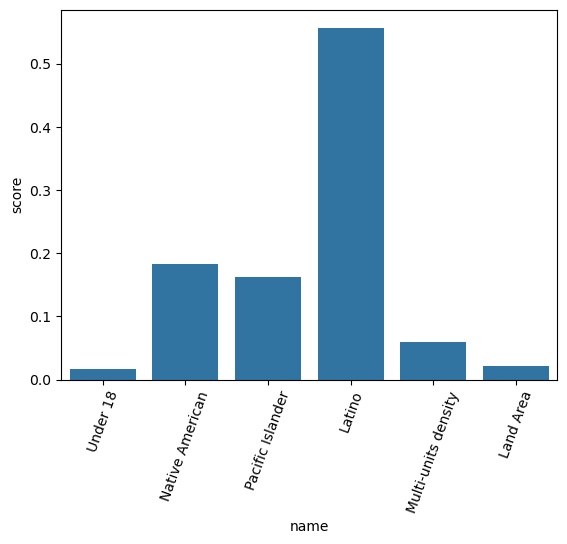

In [35]:
ax = sns.barplot(x='name', y='score', data=important_features)
plt.xticks(rotation=70)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0.0, 0, '0.0'),
  Text(0.1, 0, '0.1'),
  Text(0.2, 0, '0.2'),
  Text(0.30000000000000004, 0, '0.3'),
  Text(0.4, 0, '0.4'),
  Text(0.5, 0, '0.5'),
  Text(0.6000000000000001, 0, '0.6')])

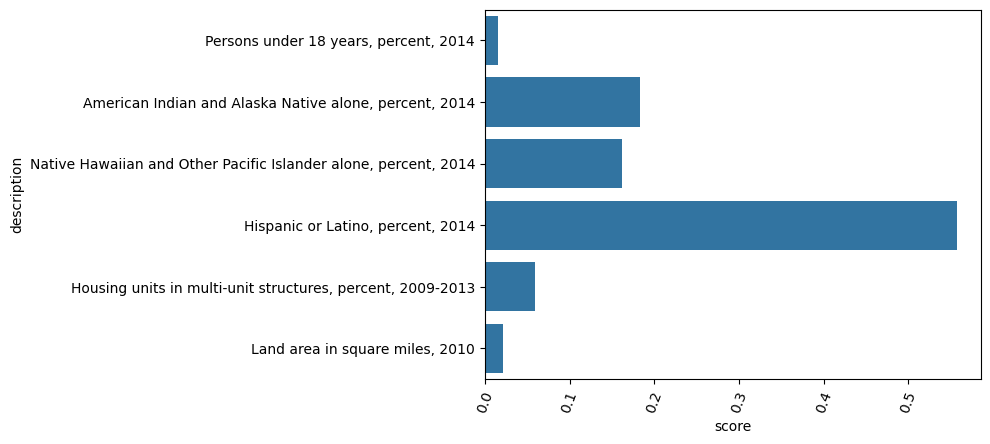

In [40]:
ax = sns.barplot(x='score', y='description', data=important_features)
plt.xticks(rotation=70)